# Quantum Key Distribution (BB84 Protocol)

No entanto, existem alguns requisitos para que este protocolo funcione:
* Tanto a Alice como o Bob têm de ter acesso ao seu próprio computador quântico.
* Têm de ter um canal de comunicação capaz de transmitir qubits. Pode ser um tipo de cabo de fibra ótica capaz de transmitir fotões polarizados.
* Devem dispor de um canal de comunicação clássico (como um cabo telefónico ou a internet).
Uma vez que é impossível garantir uma segurança perfeita, temos de assumir que qualquer um destes canais pode ser acedido pela Eve, a espiã 😈.


## Visão geral
Eis como o protocolo funciona em poucas palavras:
1. Alice cria uma sequência aleatória de bits e, para cada bit, escolhe aleatoriamente uma base para o codificar.
2. Alice codifica os bits em qubits usando as bases escolhidas e envia os qubits através de um canal de comunicação quântico para o computador quântico de Bob.
3. Bob também escolhe aleatoriamente uma base para descodificar cada qubit. Ele mede cada qubit nas bases que escolheu.
4. A Alice usa um canal de comunicação clássico para dizer ao Bob quais as bases que escolheu. Ela também lhe diz os primeiros bits que enviou.
5. Bob analisa estes primeiros bits para determinar se Eve entrou no seu canal de comunicação quântico e interceptou os qubits de Alice.
6. Se Eve *não* interceptou os qubits, eles consideram todos os qubits para os quais escolheram as mesmas bases e usam esses bits como chave. Se Eve *interceptou* os qubits, eles repetem o processo novamente.

Agora, vamos explicar o que cada um desses passos implica. **Primeiro, vamos ver como funciona se a mensagem não for interceptada por Eve**.

In [337]:
# Importing necessary Qiskit modules
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_multivector
import matplotlib.pyplot as plt

# Importing standard Python libraries
import random

simulator = AerSimulator(method='statevector')
print(simulator.available_methods)


<bound method AerSimulator.available_methods of AerSimulator('aer_simulator_statevector')>


## Codificação
O primeiro passo é a Alice escolher uma sequência de bits e bases para os codificar.

In [338]:
# Preparation for encoding
KEY_LENGTH = 500
random.seed(23) # Seed the random number generator. This will be used as our "coin flipper".

In [342]:
# Generating a random string of bits
alice_bits = ""

def gerar_bitstrings_aleatorios(num_qubits: int, num_bitstrings: int) -> str:
    """
    Gera bitstrings aleatórios usando Qiskit e retorna como uma única string.
    
    :param num_qubits: Número de qubits no circuito (também determina o comprimento dos bitstrings).
    :param num_bitstrings: Número de bitstrings a gerar.
    :return: String contendo os bitstrings gerados, separados por espaços.
    """
    # Criar o circuito quântico
    qc = QuantumCircuit(num_qubits)
    
    # Colocar todos os qubits em superposição
    for qubit in range(num_qubits):
        qc.h(qubit)  # Aplicar porta Hadamard
    
    # Adicionar medidas
    qc.measure_all()
    
    # Inicializar o simulador de Aer
    simulator = AerSimulator()
    
    # Simular o circuito
    compiled_circuit = transpile(qc)
    result = simulator.run(compiled_circuit, shots=num_bitstrings).result()
    
    # Obter os resultados das medições
    counts = result.get_counts()
    
    # Converter os resultados em uma única string de bitstrings
    bitstrings = []
    for bitstring, count in counts.items():
        bitstrings.extend([bitstring] * count)
    
    # Retornar os bitstrings como uma única string separada por espaços
    return " ".join(bitstrings)

alice_bits = gerar_bitstrings_aleatorios(KEY_LENGTH, 1)

print("The bits Alice is going to send are: " + alice_bits[:10] + "...")

The bits Alice is going to send are: 1101100001...


De seguida, Alice escolhe aleatoriamente uma base para cada bit (a base $Z$ ou a base $X$). Pode fazê-lo lançando uma moeda ao ar e escrevendo $Z$ sempre que acertar na cara e $X$ sempre que acertar na coroa.


In [308]:
def generate_random_bases(num_of_bases):
    """This function selects a random basis for each bit"""
    bases_string = ""
    for i in range(num_of_bases):
        randBasis = random.randint(0, 1) # Flip Coin

        if randBasis == 0:
            bases_string += "Z" 
        else:
            bases_string += "X"
            
    return bases_string

In [309]:
alice_bases = generate_random_bases(KEY_LENGTH) # Alice randomly chooses a basis for each bit.
    
print("The bases Alice is going to encode them in are: " + alice_bases[:10] + "...")

The bases Alice is going to encode them in are: XXZXXZZZXZ...


Agora, Alice codifica cada bit na sua base correspondente no seu computador quântico, criando uma cadeia de 500 qubits. Ela envia estes qubits através de um cabo ótico para o Bob. Vamos ver como fazer isto usando o Qiskit.

Por defeito, os computadores quânticos da IBM medem na base $Z$, e todos os qubits são inicializados com $|0\rangle$. Para transformar isto num $|1\rangle$, precisamos de aplicar uma porta $X$.

Para codificar na base $X$, começamos com o $|0\rangle$ ou $|1\rangle$ correspondente, e depois aplicamos uma porta Hadamard (H). Esta porta converte um $|0\rangle$ num $|+\rangle$ e um $|1\rangle$ num $|-\rangle$.

| Bit | Base | Estado do Qubit | Porta Necessária |
|:---:|:-----:|:-----------:|:-------------:|
| 0 | Z | $\vert0\rangle$ | Nenhum |
| 1 | Z | $\vert1\rangle$ | X |
| 0 | X | $\vert+\rangle$ | H |
| 1 | X | $\vert-\rangle$ | X então H |

Vamos armazenar o circuito quântico usado para codificar cada qubit.

In [310]:
def encode(bits, bases):
    """This function encodes each bit into the given basis."""
    
    encoded_qubits = []
    
    for bit, basis in zip(bits, bases):
        #para cada bit cria-se um circuito quantico 
        qc = QuantumCircuit(1, 1) #um qubit e um bit classico para armazenar a medição
        
        # Possible Cases
        if bit=="0" and basis == "Z":
            pass
        elif bit=="1" and basis == "Z":
            qc.x(0) # Apply X Gate
            #encoded_qubits.append(qc)
        elif bit=="0" and basis == "X":
            qc.h(0) # Apply H Gate
            #encoded_qubits.append(qc)
        elif bit=="1" and basis == "X":
            qc.x(0) # Apply X Gate
            qc.h(0) # Apply H Gate
            #encoded_qubits.append(qc)
        
        encoded_qubits.append(qc)

    return (encoded_qubits)

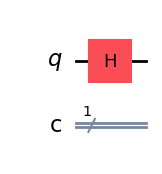

In [311]:
# Encode Alice's bits
encoded_qubits = encode(alice_bits, alice_bases)
encoded_qubits[8].draw('mpl') # exemplo

## Enviar os qubits
Normalmente, Alice enviaria esses qubits codificados através de um canal quântico, como um cabo de fibra ótica. No entanto, como ainda não temos canais quânticos no mundo real, vamos armazenar os circuitos para cada qubit numa matriz chamada `QUANTUM_CHANNEL` para fins de demonstração. Isto seria como se a Alice guardasse os qubits num edifício e esperasse que o Bob os fosse buscar. Claro que, tal como um cabo de fibra ótica, este edifício é também um local onde a Eve pode intercetar a mensagem.

In [312]:
QUANTUM_CHANNEL = encoded_qubits

## Medição
O próximo passo é o Bob receber os qubits codificados e medi-los. Primeiro, ele deve escolher seu próprio conjunto de bases aleatórias, assim como Alice.

In [313]:
bob_bases = generate_random_bases(KEY_LENGTH) # Bob randomly chooses a basis for each bit.
    
print("The bases Bob is going to decode them in are: " + bob_bases[:10] + "...")

The bases Bob is going to decode them in are: XZZXZXXZXZ...


Depois, Bob deve medir cada Qubit nas bases correspondentes que ele escolheu. No Qiskit, isto pode ser conseguido adicionando uma porta de medição ao circuito para cada qubit codificado, e depois executando-a. No entanto, os computadores quânticos da IBM medem na base $Z$ por defeito, pelo que, para medir na base $X$, temos de aplicar uma porta Hadamard antes da nossa porta de medição.

In [314]:

def measure(qubits, bases):
    """
    Esta função mede cada qubit na base correspondente escolhida para ele.
    """
    bits = ""  #Resultados das medições
    simulator = AerSimulator()  

    for idx, (qubit, basis) in enumerate(zip(qubits, bases)):
        # medir na base z (default)
        if basis == "Z":
            qubit.measure(0,0)
        #medir na base X
        elif basis == "X":
            qubit.h(0) 
            qubit.measure(0,0)

        # Run the simulation
        result = simulator.run(qubit, shots=1).result()
        counts = result.get_counts()
        measured_bit = max(counts, key=counts.get)  # Retrieve the measured bit

        # Debug: Print qubit, base, and measured bit for the first 10 measurements
        if idx < 10:
            print(f"Measurement {idx + 1}: Base = {basis}, Measured Bit = {measured_bit}")
        bits += measured_bit

    return bits


In [315]:
qubits_received = QUANTUM_CHANNEL # Receive qubits from quantum channel
bob_bits = measure(qubits_received, bob_bases)
print("The first few bits Bob received are: " + bob_bits[:10] + "..., of ", len(bob_bits))


Measurement 1: Base = X, Measured Bit = 1
Measurement 2: Base = Z, Measured Bit = 0
Measurement 3: Base = Z, Measured Bit = 0
Measurement 4: Base = X, Measured Bit = 1
Measurement 5: Base = Z, Measured Bit = 1
Measurement 6: Base = X, Measured Bit = 1
Measurement 7: Base = X, Measured Bit = 1
Measurement 8: Base = Z, Measured Bit = 0
Measurement 9: Base = X, Measured Bit = 0
Measurement 10: Base = Z, Measured Bit = 1
The first few bits Bob received are: 1001111001..., of  500


## Comparação
Agora, a Alice precisa de dizer ao Bob quais as bases que escolheu para codificar os seus qubits. Ela pode dizer-lhe através de qualquer canal clássico. A beleza deste protocolo é que não importa se Eve descobre quais bases Alice usou.

In [316]:
CLASSICAL_CHANNEL = alice_bases # Alice tells Bob which bases she used

Para cada um dos qubits em que Alice e Bob escolheram bases diferentes, há 50% de chance de a medição de Bob retornar o qubit errado. Por exemplo, se Alice enviou a Bob um qubit no estado $|+\rangle$ (i.e., um valor de bit 0 codificado na base $X$), e Bob mede na base $Z$, há 50% de chance de ele obter um $|0\rangle$ e 50% de chance de obter um $|1\rangle$.Assim, cada instância em que as suas bases não coincidem é inútil para eles, pelo que o Bob precisa de encontrar as bases que partilham em comum.

In [317]:
# Store the indices of the bases they share in common
common_bases = [i for i in range(KEY_LENGTH) if CLASSICAL_CHANNEL[i]==bob_bases[i]]

print("The indices of the first 10 bases they share in common are: " + str(common_bases[:10]))

The indices of the first 10 bases they share in common are: [0, 2, 3, 7, 8, 9, 14, 19, 21, 22]


Agora que o Bob sabe as bases que partilham em comum, pode discartar o resto dos bits, e manter apenas os que foram medidos nas mesmas bases.

In [318]:
bob_bits_compared = [bob_bits[index] for index in common_bases]  # Filtra os bits de Bob com base em common_bases
# Converte os primeiros 10 bits para uma string antes de concatenar
print("The first 10 bits measured on the same bases are: " + ''.join(bob_bits_compared[:10]) + "..., de ", len(bob_bits_compared))


The first 10 bits measured on the same bases are: 1010010010..., de  241


Ele tambem informa a Alice das bases que usou para ela poder discartar o resto do bits, mantendo apenas os bits  que foram medidos por bob na mesma base que ela os codificou.

In [319]:
CLASSICAL_CHANNEL = common_bases # Bob tells Alice which bases they shared in common

In [320]:
alice_bits_compared = [alice_bits[index] for index in common_bases] # Alice keeps only the bits they shared in common
print("The first 10 bits measured by bob on the same bases that they are encoded: " + ''.join(alice_bits_compared[:10]) + "..., em ", len(alice_bits_compared))

The first 10 bits measured by bob on the same bases that they are encoded: 1010010010..., em  241


Uma vez que ambos estão a manter em comum os bits medidos nas bases que partilharam, *deveriam* ter os mesmos bits. Para termos a certeza de que isso acontece, a Alice anuncia os primeiros bits que tem, e o Bob devera ter os mesmos. Claro que, se Eve estivesse a tentar escutar, também ouviria esses primeiros bits, pelo que a Alice e o Bob também teriam de os descartar (depois de os compararem para se certificarem de que são iguais ao que esperam).

In [321]:
CLASSICAL_CHANNEL = alice_bits_compared[:100] # Alice tells Bob the first 100 bits she has left.

# Bob checks if they match the first 100 bits that he has
if CLASSICAL_CHANNEL == bob_bits_compared[:100]:
    print("Yep, Alice and Bob seem to have the same bits!")
else:
    print("Uh oh, at least one of the bits is different.")

Yep, Alice and Bob seem to have the same bits!


Uma vez que os primeiros 100 bits são iguais, Alice e Bob podem ter quase a certeza de que os restantes bits também são iguais. Agora, precisam de descartar os primeiros 100 bits, uma vez que a Eve pode ter estado a ouvir o canal clássico e a registar o que são.

In [322]:
alice_bits_final = alice_bits_compared[100:] # Alice discards the first 100 bits
bob_bits_final = alice_bits_compared[100:] # Alice discards the first 100 bits

Estes bits restantes são a chave 🔑 que a Alice e o Bob precisam para estabelecer um canal de comunicação encriptado! Agora podem comunicar sem se preocuparem com o facto de as suas mensagens serem lidas por outra pessoa!

In [323]:
key = "" 
for bit in alice_bits_final: # Or bob_bits, since both should be the same
    key += bit

print("Shhhhh, the key is:")
print(str(key))
print("Don't tell anyone!")

print("\nThe key is " + str(len(key)) + " bits long.")

Shhhhh, the key is:
011100001011011111110101001110011111101000000000011001110100010010011010001101000111100110111101101101000010110011111110010101101101100001101
Don't tell anyone!

The key is 141 bits long.


### Eficiência do Protocolo (Sem ruido)

Eficiência do Protocolo (SIMULADO SEM RUIDO): 96.40%


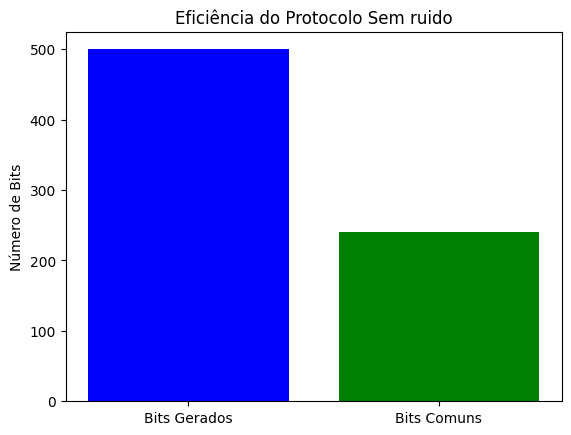

In [324]:
# Cálculo da eficiência (percentagem de bits válidos em relação aos gerados)
num_bits_comuns = len(common_bases)
eficiencia = ((num_bits_comuns) / (KEY_LENGTH)) * 100 *2
print(f"Eficiência do Protocolo (SIMULADO SEM RUIDO): {eficiencia:.2f}%")

# Adicionando um gráfico de barras
fig, ax = plt.subplots()
ax.bar(["Bits Gerados", "Bits Comuns"], [KEY_LENGTH, num_bits_comuns], color=['blue', 'green'])
ax.set_title("Eficiência do Protocolo Sem ruido")
ax.set_ylabel("Número de Bits")
plt.show()

## Interceção
___
Até agora, apenas analisámos o caso em que ninguém espia a Alice e o Bob. Mas e se alguém como a Eva tentar intercetar a chave deles? Vamos ver o que acontece neste caso.

Primeiro, Alice executa o passo de codificação como habitualmente (ja feito): gera aleatoriamente uma cadeia de bits e bases para os codificar. Em seguida, envia os qubits codificados ao longo de um canal quântico (cabo de fibra ótica) para Bob.

In [325]:
# Alice randomly chooses a basis for each bit.
alice_bases = gerar_bitstrings_aleatorios(KEY_LENGTH)

# Encode Alice's bits
encoded_qubits = encode(alice_bits, alice_bases)

QUANTUM_CHANNEL = encoded_qubits

### ⚠️ Interceção por eavesdropper⚠️
Desta vez, os qubits são interceptados pela 😈 Eve. Vamos ver o que ela faria. Primeiro, ela escolheria aleatoriamente um conjunto de bases para medir os qubits (já que ela não tem ideia de quais bases Alice usou). Depois, ela efectua as medições. Isto é semelhante ao que o Bob faria normalmente.

In [326]:
qubits_intercepted = QUANTUM_CHANNEL # Intercept qubits
eve_bases = generate_random_bases(KEY_LENGTH) # Generate a random set of bases
eve_bits = measure(qubits_intercepted, eve_bases) # Measure the qubits

Measurement 1: Base = Z, Measured Bit = 1
Measurement 2: Base = X, Measured Bit = 0
Measurement 3: Base = Z, Measured Bit = 1
Measurement 4: Base = Z, Measured Bit = 0
Measurement 5: Base = Z, Measured Bit = 0
Measurement 6: Base = Z, Measured Bit = 1
Measurement 7: Base = X, Measured Bit = 0
Measurement 8: Base = X, Measured Bit = 1
Measurement 9: Base = X, Measured Bit = 0
Measurement 10: Base = X, Measured Bit = 1


Devido ao Teorema da Não-Clonagem da Mecânica Quântica, Eva não pode simplesmente copiar os qubits do canal quântico. Assim, Bob nunca irá receber os qubits, tornando óbvio para ele e Alice que a sua mensagem foi interceptada.Para evitar que eles se apercebam do que aconteceu, Eva tem de criar os seus próprios qubits de engodo para enviar a Bob.Uma vez que não faz ideia de que bases Alice usou, tem de gerar as bases aleatoriamente.Isto é semelhante ao que Alice fez originalmente quando codificou os qubits. 

A Eve pode gerar um conjunto de bases totalmente novo, ou pode simplesmente usar as mesmas que usou para medir os qubits. Para simplificar, vamos assumir que as bases que ela usou para intercetar os qubits são as mesmas bases que ela usou para codificar seus qubits chamarizes.

In [327]:
# Eve encodes her decoy qubits and sends them along the quantum channel
QUANTUM_CHANNEL = encode(eve_bits, eve_bases)

Bob executa então os seus passos habituais: selecionar uma base de medição e medir os qubits. Ele ainda não sabe que Eva os interceptou.

In [328]:
bob_bases = generate_random_bases(KEY_LENGTH) # Bob randomly chooses a basis for each bit.
qubits_received = QUANTUM_CHANNEL # Receive qubits from quantum channel
bob_bits = measure(qubits_received, bob_bases)

Measurement 1: Base = X, Measured Bit = 1
Measurement 2: Base = Z, Measured Bit = 1
Measurement 3: Base = Z, Measured Bit = 1
Measurement 4: Base = X, Measured Bit = 1
Measurement 5: Base = Z, Measured Bit = 0
Measurement 6: Base = Z, Measured Bit = 1
Measurement 7: Base = X, Measured Bit = 0
Measurement 8: Base = Z, Measured Bit = 1
Measurement 9: Base = X, Measured Bit = 0
Measurement 10: Base = X, Measured Bit = 1


### Comparação
Mais uma vez, Alice precisa de dizer a Bob quais as bases que escolheu para codificar os seus qubits. Ela pode dizer-lhe através de qualquer canal clássico. Como este canal clássico é público, a Eve também sabe quais as bases que ela usou

In [329]:
CLASSICAL_CHANNEL = alice_bases # Alice tells Bob which bases she used

Como é habitual, o Bob verifica quais as bases que partilham em comum. Ele descarta os bits que não foram medidos nas mesmas bases e mantém os que foram medidos nas mesmas bases em que Alice os codificou.


In [330]:
# Store the indices of the bases they share in common
common_bases_eve = [i for i in range(KEY_LENGTH) if CLASSICAL_CHANNEL[i]==bob_bases[i]]
bob_bits_compared_eve = [bob_bits[index] for index in common_bases]
print("The first 10 bits measured on the same bases are: " + ''.join(bob_bits_compared_eve[:10]) + "... em " ,len(bob_bits_compared_eve) , "bits")

The first 10 bits measured on the same bases are: 1111011110... em  241 bits


Depois, diz à Alice os índices das bases que têm em comum para que ela possa fazer o mesmo.


In [331]:
CLASSICAL_CHANNEL = common_bases_eve # Bob tells Alice which bases they shared in common
alice_bits_compared_eve = [alice_bits[index] for index in common_bases_eve] # Alice keeps only the bits they shared in common
print("The first 10 bits measured by bob on the same bases that they are encoded: " + ''.join(alice_bits_compared_eve[:10]))

The first 10 bits measured by bob on the same bases that they are encoded: 1111111001


### Atenção...!
Uma vez que a Alice e o Bob só estão a guardar os bits medidos nas bases que partilharam em comum, eles *devem* ter os mesmos bits. Para ter certeza de que esse é o caso, Alice vai anunciar os primeiros bits que ela tem, e Bob deve ter os mesmos.

In [332]:
# Alice tells Bob the first 100 bits she has left
CLASSICAL_CHANNEL = alice_bits_compared_eve[:100]

# Comparar os bits de Alice e Bob
bits_diferentes = sum(1 for a, b in zip(CLASSICAL_CHANNEL, bob_bits_compared_eve[:100]) if a != b)

# Verificar se os bits coincidem
if bits_diferentes == 0:
    print("Yep, Alice and Bob seem to have the same bits!")
else:
    print(f"Ups, {bits_diferentes} bits são diferentes entre Alice e Bob.")

Ups, 40 bits são diferentes entre Alice e Bob.


Depois de compararem os primeiros 100 bits, verificam que os seus bits não coincidem! Assumindo que não há ruído no canal quântico e nos computadores quânticos (que poderia causar erros), Alice e Bob podem ter a certeza de que a sua mensagem foi interceptada! Assim, podem deitar fora todos os seus bits e repetir o mesmo protocolo de novo. Desta vez, podem usar um canal quântico diferente para tentar despistar a Eva!

### Eficiência do Protocolo (Com ruido da interceção)

Eficiência do Protocolo (SIMULADO COM RUIDO Interceção): 80.40%


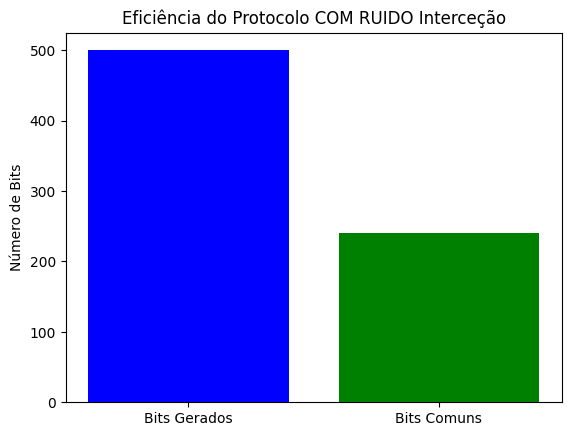

In [343]:
# Cálculo da eficiência (percentagem de bits válidos em relação aos gerados)
num_bits_comuns = len(common_bases)
eficiencia = ((num_bits_comuns-bits_diferentes) / (KEY_LENGTH)) * 100 *2
print(f"Eficiência do Protocolo (SIMULADO COM RUIDO Interceção): {eficiencia:.2f}%")

# Adicionando um gráfico de barras
fig, ax = plt.subplots()
ax.bar(["Bits Gerados", "Bits Comuns"], [KEY_LENGTH, num_bits_comuns], color=['blue', 'green'])
ax.set_title("Eficiência do Protocolo COM RUIDO Interceção")
ax.set_ylabel("Número de Bits")
plt.show()

___
## Referencias
* Qiskit Textbook: https://qiskit.org/textbook/ch-algorithms/quantum-key-distribution.html
* Class Notebook: CQ_DEEC_jlobo_02_using_a_real_quantum_computer.ipynb